## Setup

In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchtext.datasets import AG_NEWS
train_iter = AG_NEWS(split='train')

### Set up data related stuff

In [80]:
# check here for details https://github.com/pytorch/text/blob/main/torchtext/data/utils.py#L52-#L166
from torchtext.data.utils import get_tokenizer
# check here for details https://github.com/pytorch/text/blob/main/torchtext/vocab/vocab_factory.py#L65-L113
from torchtext.vocab import build_vocab_from_iterator

# A tokenizer splits a input setence into a set of tokens, including those puncuation
# For example
# >>> tokens = tokenizer("You can now install TorchText using pip!")
# >>> tokens
# >>> ['you', 'can', 'now', 'install', 'torchtext', 'using', 'pip', '!']
tokenizer = get_tokenizer('basic_english')

train_iter = AG_NEWS(split='train')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

# Creates a vocab object which maps tokens to indices
# Check here for details https://github.com/pytorch/text/blob/main/torchtext/vocab/vocab.py
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])

# The specified token will be returned when a out-of-vocabulary token is queried.
vocab.set_default_index(vocab["<unk>"])

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

# The padding token we need to use
# The returned indices are always in an array
PAD_TOKEN = vocab(tokenizer('<pad>'))
assert len(PAD_TOKEN) == 1
PAD_TOKEN = PAD_TOKEN[0]

In [3]:
# Documentation of DataLoader https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
from torch.utils.data import DataLoader

# Merges a list of samples to form a mini-batch of Tensor(s)
def collate_batch(batch):
    """
    Input:
    - batch: A list of data in a mini batch, where the length denotes the batch size.
      The actual context depends on a particular dataset. In our case, each position
      contains a label and a Tensor (tokens in a sentence).

    Returns:
    - batched_label: A Tensor with the shape of (B,)
    - batched_text: A Tensor with the shape of (B, L, C), where L is the sequence length
      and C is the channeld dimension
    """
    label_list, text_list, text_len_list = [], [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        text_len_list.append(processed_text.size(0))
    batched_label, batched_text = None, None

    max_len = max(text_len_list)
    batched_label = torch.tensor(label_list)
    for i in range(len(text_list)):
      padding = torch.tensor([PAD_TOKEN for _ in range(max_len-len(text_list[i]))])
      text_list[i] = torch.cat((text_list[i], padding), 0)
    batched_text = torch.stack(text_list)

    return batched_label.long(), batched_text.long()

# Now, let's check what the batched data looks like
train_iter = AG_NEWS(split='train')
dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)
for idx, (label, data) in enumerate(dataloader):
    if idx > 0:
        break
    print('label.shape: {}'.format(label.shape))
    print('label: {}'.format(label))
    print('data.shape: {}'.format(data.shape))

label.shape: torch.Size([8])
label: tensor([2, 2, 2, 2, 2, 2, 2, 2])
data.shape: torch.Size([8, 49])


In [81]:
import time

def train(model, dataloader, loss_func, device, grad_norm_clip):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()
    softmax = nn.Softmax(dim=1)

    for idx, (label, text) in enumerate(dataloader):
        label = label.to(device)
        text = text.to(device)
        optimizer.zero_grad()

        logits = None
        logits = model(text)
        classes = softmax(logits)
        loss = loss_func(classes, label)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
        optimizer.step()
        total_acc += (logits.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(model, dataloader, loss_func, device):
    model.eval()
    total_acc, total_count = 0, 0
    softmax = nn.Softmax(dim=1)

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            label = label.to(device)
            text = text.to(device)

            logits = model(text)
            classes = softmax(logits)
            loss = loss_func(classes, label)

            total_acc += (logits.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [5]:
class MultiHeadAttention(nn.Module):
    """
    A module that computes multi-head attention given query, key, and value tensors.
    """
    def __init__(self, input_dim: int, num_heads: int):
        """
        Constructor.

        Inputs:
        - input_dim: Dimension of the input query, key, and value. Here we assume they all have
          the same dimensions. But they could have different dimensions in other problems.
        - num_heads: Number of attention heads
        """
        super(MultiHeadAttention, self).__init__()

        assert input_dim % num_heads == 0

        self.input_dim = input_dim
        self.num_heads = num_heads
        self.dim_per_head = input_dim // num_heads


        self.key_fc = nn.Linear(input_dim, input_dim)
        self.value_fc = nn.Linear(input_dim, input_dim)
        self.query_fc = nn.Linear(input_dim, input_dim)
        self.output_fc = nn.Linear(input_dim, input_dim)


    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor=None):
        """
        Compute the attended feature representations.

        Inputs:
        - query: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - key: Tensor of the shape BxLxC
        - value: Tensor of the shape BxLxC
        - mask: Tensor indicating where the attention should *not* be performed
        """
        b = query.shape[0]

        dot_prod_scores = None

        query = self.query_fc(query)
        key = self.key_fc(key)
        value = self.value_fc(value)

        query_l, key_l, value_l = query.shape[1], key.shape[1], value.shape[1]

        # embeddings are split into dim_per_head parts
        # query shape: (B, query_l, num_heads, dim_per_head)
        # key shape  : (B, key_len, num_heads, dim_per_head)
        # value shape: (B, value_l, num_heads, dim_per_head)
        query = query.reshape(b, query_l, self.num_heads, self.dim_per_head)
        key = key.reshape(b, key_l, self.num_heads, self.dim_per_head)
        value = value.reshape(b, key_l, self.num_heads, self.dim_per_head)

        query = query.transpose(1, 2)             # [B, num_heads, query_l, dim_per_head]
        key = key.transpose(1, 2).transpose(2, 3) # [B, num_heads, dim_per_head, key_len]
        value = value.transpose(1, 2)             # [B, num_heads, value_l, dim_per_head]


        # d ot_prod_scores shape: [B, num_heads, query_l, key_l]
        dot_prod_scores = torch.matmul(query, key)


        if mask is not None:
            # We simply set the similarity scores to be near zero for the positions
            # where the attention should not be done. Think of why we do this.
            dot_prod_scores = dot_prod_scores.masked_fill(mask == 0, -1e9)

        out = None

        # attention shape: [B, num_heads, query_l, key_l]
        # value shape:     [B, num_heads, value_l, dim_per_head]
        attention = torch.softmax(dot_prod_scores/(self.input_dim**(1/2)), dim=3)
        out = attention.matmul(value) # [B, num_heads, query_l, dim_per_head]
        out = out.transpose(1, 2)     # [B, query_l, num_heads, dim_per_head]
        out = out.reshape(b, -1, self.num_heads * self.dim_per_head) #[B,L,C]

        out = self.output_fc(out)

        return out

In [6]:
x = torch.randn((2, 10, 8))
mask = torch.randn((2, 10)) > 0.5
mask = mask.unsqueeze(1).unsqueeze(-1)
num_heads = 4
model = MultiHeadAttention(8, num_heads)
y = model(x, x, x, mask)
assert len(y.shape) == len(x.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


In [7]:
class FeedForwardNetwork(nn.Module):
    """
    A simple feedforward network. Essentially, it is a two-layer fully-connected
    neural network.
    """
    def __init__(self, input_dim, ff_dim, dropout):
        """
        Inputs:
        - input_dim: Input dimension
        - ff_dim: Hidden dimension
        """
        super(FeedForwardNetwork, self).__init__()

        self.linear1 = nn.Linear(input_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, input_dim)
        self.non_linear = nn.ReLU()


    def forward(self, x: torch.Tensor):
        """
        Input:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
         and C is the channel dimension

        Return:
        - y: Tensor of the shape BxLxC
        """

        y = None

        y = self.linear1(x)
        y = self.non_linear(y)
        y = self.linear2(y)

        return y


In [8]:
x = torch.randn((2, 10, 8))
ff_dim = 4
model = FeedForwardNetwork(8, ff_dim, 0.1)
y = model(x)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


In [13]:
class TransformerEncoderCell(nn.Module):
    """
    A single cell (unit) for the Transformer encoder.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, dropout: float):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoderCell, self).__init__()

        self.attention = MultiHeadAttention(input_dim, num_heads)
        self.dropout = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.fc = FeedForwardNetwork(input_dim, ff_dim, dropout)

    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - mask: Tensor for multi-head attention
        """

        y = None

        attention = self.attention(x,x,x,mask)
        attention = self.dropout(attention)
        x = self.norm1(attention+x)
        forward = self.fc(x)
        forward = self.dropout(forward)
        y = self.norm2(forward+x)

        return y

In [14]:
x = torch.randn((2, 10, 8))
mask = torch.randn((2, 10)) > 0.5
mask = mask.unsqueeze(1).unsqueeze(-1)
num_heads = 4
model = TransformerEncoderCell(8, num_heads, 32, 0.1)
y = model(x, mask)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


In [15]:
class TransformerEncoder(nn.Module):
    """
    A full encoder consisting of a set of TransformerEncoderCell.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, num_cells: int, dropout: float=0.1):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: Number of TransformerEncoderCells
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoder, self).__init__()
        self.norm = None
        self.layers = nn.ModuleList(
            [TransformerEncoderCell(input_dim, num_heads, ff_dim, dropout) for _ in range(num_cells)]
        )
        self.norm = nn.LayerNorm(input_dim)


    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - mask: Tensor for multi-head attention

        Return:
        - y: Tensor of the shape of BxLxC, which is the normalized output of the encoder
        """

        y = None
        for layer in self.layers:
          x = layer(x,mask)

        y = self.norm(x)

        return y


In [16]:
x = torch.randn((2, 10, 8))
mask = torch.randn((2, 10)) > 0.5
mask = mask.unsqueeze(1).unsqueeze(-1)
num_heads = 4
model = TransformerEncoder(8, num_heads, 32, 2, 0.1)
y = model(x)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


In [17]:
class PositionalEncoding(nn.Module):
    """
    A module that adds positional encoding to each of the token's features.
    So that the Transformer is position aware.
    """
    def __init__(self, input_dim: int, max_len: int=10000):
        """
        Inputs:
        - input_dim: Input dimension about the features for each token
        - max_len: The maximum sequence length
        """
        super(PositionalEncoding, self).__init__()

        self.input_dim = input_dim

    def forward(self, x):
        """
        Compute the positional encoding and add it to x.

        Input:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension

        Return:
        - x: Tensor of the shape BxLxC, with the positional encoding added to the input
        """
        seq_len = x.shape[1]
        input_dim = x.shape[2]

        pe = torch.zeros(seq_len, input_dim, requires_grad=False)

        for pos in range(seq_len):
            for i in range(0, input_dim, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/input_dim)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * i)/input_dim)))
        pe = pe.reshape(1, seq_len, input_dim)


        x = x + pe.to(x.device)
        return x

In [18]:
# Sanity check
x = torch.randn(1, 100, 20)
pe = PositionalEncoding(20)
y = pe(x)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y

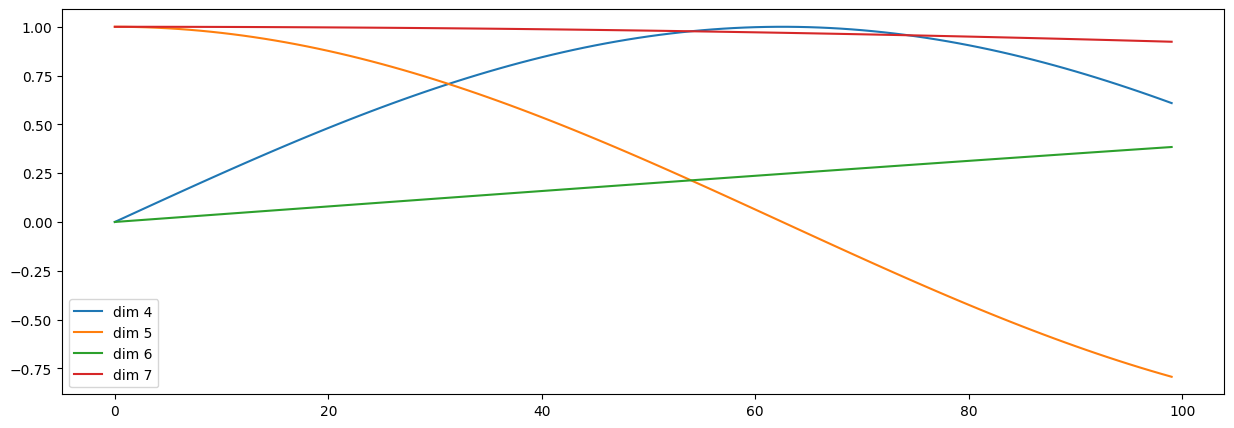

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward((torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

In [20]:
class TransformerClassifier(nn.Module):
    """
    A Transformer-based text classifier.
    """
    def __init__(self,
            vocab_size: int, embed_dim: int, num_heads: int, trx_ff_dim: int,
            num_trx_cells: int, num_class: int, dropout: float=0.1, pad_token: int=0
        ):
        """
        Inputs:
        - vocab_size: Vocabulary size, indicating how many tokens we have in total.
        - embed_dim: The dimension of word embeddings
        - num_heads: Number of attention heads in a multi-head attention module
        - trx_ff_dim: The hidden dimension for a feedforward network
        - num_trx_cells: Number of TransformerEncoderCells
        - dropout: Dropout ratio
        - pad_token: The index of the padding token.
        """
        super(TransformerClassifier, self).__init__()

        self.embed_dim = embed_dim

        # word embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_token)


        self.pe = PositionalEncoding(embed_dim)
        self.transformer_encoder = TransformerEncoder(embed_dim, num_heads, trx_ff_dim, num_trx_cells, dropout)
        self.output_fc = nn.Linear(embed_dim, num_class)


    def forward(self, text, mask=None):
        """
        Inputs:
        - text: Tensor with the shape of BxLxC.
        - mask: Tensor for multi-head attention

        Return:
        - logits: Tensor with the shape of BxK, where K is the number of classes
        """

        # word embeddings, note we multiple the embeddings by a factor
        embedded = self.embedding(text) * math.sqrt(self.embed_dim)

        embedded_pe = self.pe(embedded)
        enc_out = self.transformer_encoder(embedded_pe)
        logits = torch.mean(enc_out, 1)
        logits = self.output_fc(logits)

        return logits

In [21]:
vocab_size = 10
embed_dim = 16
num_heads = 4
trx_ff_dim = 16
num_trx_cells = 2
num_class = 3

x = torch.arange(vocab_size).view(1, -1)
x = torch.cat((x, x), dim=0)
mask = (x != 0).unsqueeze(-2).unsqueeze(1)
model = TransformerClassifier(vocab_size, embed_dim, num_heads, trx_ff_dim, num_trx_cells, num_class)
print('x: {}, mask: {}'.format(x.shape, mask.shape))
y = model(x, mask)
assert len(y.shape) == 2 and y.shape[0] == x.shape[0] and y.shape[1] == num_class
print(y.shape)

x: torch.Size([2, 10]), mask: torch.Size([2, 1, 1, 10])
torch.Size([2, 3])


In [23]:
assert torch.cuda.is_available()
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
# device = 'cuda'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
epochs = 5 # epoch
lr = 0.0005  # learning rate
batch_size = 64 # batch size for training

train_iter = AG_NEWS(split='train')
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 64

num_heads = 4
num_trx_cells = 2

gradient_norm_clip = 1

model = TransformerClassifier(vocab_size,embed_dim, num_heads, emsize, num_trx_cells, num_class)
loss_func = nn.CrossEntropyLoss()

model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 1e-8)
total_accu = None


train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = random_split(
    train_dataset,
    [num_train, len(train_dataset) - num_train]
)

train_dataloader = DataLoader(
    split_train_, batch_size=batch_size,
    shuffle=True, collate_fn=collate_batch
)

valid_dataloader = DataLoader(
    split_valid_, batch_size=batch_size,
    shuffle=False, collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size,
    shuffle=False, collate_fn=collate_batch
)

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model, train_dataloader, loss_func, device, gradient_norm_clip)
    accu_val = evaluate(model, valid_dataloader, loss_func, device)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   500/ 1782 batches | accuracy    0.433
| epoch   1 |  1000/ 1782 batches | accuracy    0.620
| epoch   1 |  1500/ 1782 batches | accuracy    0.692
-----------------------------------------------------------
| end of epoch   1 | time: 51.15s | valid accuracy    0.737 
-----------------------------------------------------------
| epoch   2 |   500/ 1782 batches | accuracy    0.757
| epoch   2 |  1000/ 1782 batches | accuracy    0.779
| epoch   2 |  1500/ 1782 batches | accuracy    0.795
-----------------------------------------------------------
| end of epoch   2 | time: 48.44s | valid accuracy    0.790 
-----------------------------------------------------------
| epoch   3 |   500/ 1782 batches | accuracy    0.820
| epoch   3 |  1000/ 1782 batches | accuracy    0.826
| epoch   3 |  1500/ 1782 batches | accuracy    0.833
-----------------------------------------------------------
| end of epoch   3 | time: 48.50s | valid accuracy    0.821 
-------------------------------

# Fastformer Implementaion

Implementing the attention mechanism modification mentioned in the paper Fastformer to speed up the transformer architecture. https://arxiv.org/abs/2108.09084.

<br>
The query-key inner product being a quadratic operation makes the transformer slow in nature. The paper proposes to speed up the the attention mechanism by aggrigating the query vectors using a weighted sum.

This aggrigated query vector is multiplied with each key vector and is suggested as a replacement for the vanila attention mechanism. This process is further repeated for the key and value vector pair.

Though aggrigating all the queries reduces the expresibility of the model, the paper claims that the performance loss in the negligible compared to the reduction in training time even for complex tasks.

In [70]:
x = torch.randn((2, 10, 8))
mask = torch.randn((2, 10)) > 0.5
mask = mask.unsqueeze(-1)

num_heads = 4
model = FastMultiHeadAttention(8, num_heads)
y = model(x, x, x, mask)
assert len(y.shape) == len(x.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


In [71]:
class FastTransformerEncoderCell(nn.Module):
    """
    A single cell (unit) for the Transformer encoder.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, dropout: float):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(FastTransformerEncoderCell, self).__init__()


        self.attention = FastMultiHeadAttention(input_dim, num_heads)
        self.dropout = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.fc = FeedForwardNetwork(input_dim, ff_dim, dropout)


    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - mask: Tensor for multi-head attention
        """

        y = None

        attention = self.attention(x,x,x,mask)
        attention = self.dropout(attention)
        x = self.norm1(attention+x)
        forward = self.fc(x)
        forward = self.dropout(forward)
        y = self.norm2(forward+x)

        return y

In [72]:
x = torch.randn((2, 10, 8))
mask = torch.randn((2, 10)) > 0.5
mask = mask.unsqueeze(1).unsqueeze(-1)
num_heads = 4
model = FastTransformerEncoderCell(8, num_heads, 32, 0.1)
y = model(x, mask)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


In [73]:
class FastTransformerEncoder(nn.Module):
    """
    A full encoder consisting of a set of TransformerEncoderCell.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, num_cells: int, dropout: float=0.1):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: Number of TransformerEncoderCells
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(FastTransformerEncoder, self).__init__()

        self.norm = None

        self.layers = nn.ModuleList(
            [FastTransformerEncoderCell(input_dim, num_heads, ff_dim, dropout) for _ in range(num_cells)]
        )
        self.norm = nn.LayerNorm(input_dim)


    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - mask: Tensor for multi-head attention

        Return:
        - y: Tensor of the shape of BxLxC, which is the normalized output of the encoder
        """

        y = None

        for layer in self.layers:
          x = layer(x,mask)

        y = self.norm(x)


        return y


In [74]:
x = torch.randn((2, 10, 8))
mask = torch.randn((2, 10)) > 0.5
mask = mask.unsqueeze(1).unsqueeze(-1)
num_heads = 4
model = FastTransformerEncoder(8, num_heads, 32, 2, 0.1)
y = model(x)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


In [75]:
class FastTransformerClassifier(nn.Module):
    """
    A Transformer-based text classifier.
    """
    def __init__(self,
            vocab_size: int, embed_dim: int, num_heads: int, trx_ff_dim: int,
            num_trx_cells: int, num_class: int, dropout: float=0.1, pad_token: int=0
        ):
        """
        Inputs:
        - vocab_size: Vocabulary size, indicating how many tokens we have in total.
        - embed_dim: The dimension of word embeddings
        - num_heads: Number of attention heads in a multi-head attention module
        - trx_ff_dim: The hidden dimension for a feedforward network
        - num_trx_cells: Number of TransformerEncoderCells
        - dropout: Dropout ratio
        - pad_token: The index of the padding token.
        """
        super(FastTransformerClassifier, self).__init__()

        self.embed_dim = embed_dim

        # word embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_token)


        self.pe = PositionalEncoding(embed_dim)
        self.fast_transformer_encoder = FastTransformerEncoder(embed_dim, num_heads, trx_ff_dim, num_trx_cells, dropout)
        self.output_fc = nn.Linear(embed_dim, num_class)


    def forward(self, text, mask=None):
        """
        Inputs:
        - text: Tensor with the shape of BxLxC.
        - mask: Tensor for multi-head attention

        Return:
        - logits: Tensor with the shape of BxK, where K is the number of classes
        """

        # word embeddings, note we multiple the embeddings by a factor
        embedded = self.embedding(text) * math.sqrt(self.embed_dim)

        logits = None

        embedded_pe = self.pe(embedded)
        enc_out = self.fast_transformer_encoder(embedded_pe)
        logits = torch.mean(enc_out, 1)
        logits = self.output_fc(logits)


        return logits

In [76]:
vocab_size = 10
embed_dim = 16
num_heads = 4
trx_ff_dim = 16
num_trx_cells = 2
num_class = 3

x = torch.arange(vocab_size).view(1, -1)
x = torch.cat((x, x), dim=0)
mask = (x != 0).unsqueeze(-2).unsqueeze(1)
model = FastTransformerClassifier(vocab_size, embed_dim, num_heads, trx_ff_dim, num_trx_cells, num_class)
print('x: {}, mask: {}'.format(x.shape, mask.shape))
y = model(x, mask)
assert len(y.shape) == 2 and y.shape[0] == x.shape[0] and y.shape[1] == num_class
print(y.shape)

x: torch.Size([2, 10]), mask: torch.Size([2, 1, 1, 10])
torch.Size([2, 3])


In [84]:
assert torch.cuda.is_available()
# device = 'cuda'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
epochs = 5 # epoch
lr = 0.005  # learning rate changed from 0.0005
batch_size = 64 # batch size for training

train_iter = AG_NEWS(split='train')
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 64

num_heads = 4
num_trx_cells = 2

gradient_norm_clip = 1

model = FastTransformerClassifier(vocab_size,embed_dim, num_heads, emsize, num_trx_cells, num_class)
loss_func = nn.CrossEntropyLoss()

model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 1e-8)
total_accu = None

# You should be able to get a validation accuracy around 89%
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model, train_dataloader, loss_func, device, gradient_norm_clip)
    accu_val = evaluate(model, valid_dataloader, loss_func, device)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   500/ 1782 batches | accuracy    0.651
| epoch   1 |  1000/ 1782 batches | accuracy    0.833
| epoch   1 |  1500/ 1782 batches | accuracy    0.858
-----------------------------------------------------------
| end of epoch   1 | time: 48.09s | valid accuracy    0.875 
-----------------------------------------------------------
| epoch   2 |   500/ 1782 batches | accuracy    0.893
| epoch   2 |  1000/ 1782 batches | accuracy    0.896
| epoch   2 |  1500/ 1782 batches | accuracy    0.896
-----------------------------------------------------------
| end of epoch   2 | time: 52.80s | valid accuracy    0.875 
-----------------------------------------------------------
| epoch   3 |   500/ 1782 batches | accuracy    0.912
| epoch   3 |  1000/ 1782 batches | accuracy    0.912
| epoch   3 |  1500/ 1782 batches | accuracy    0.910
-----------------------------------------------------------
| end of epoch   3 | time: 47.21s | valid accuracy    0.889 
-------------------------------

The model with the modified attention mechanism seems to be running slightly faster than the vanila attention mechanism. Though there is a huge variablity in the epoch to epoch training time.